In [1]:
import os 
import sys
import time

paths_to_add = [
    os.path.abspath(os.path.join('../..')),  
    os.path.abspath(os.path.join('..'))  
]

sys.path.extend(path for path in paths_to_add if path not in sys.path)

In [2]:
import jax
from jax import jit, vmap
import jax.numpy as jnp
import numpy as np
import scipy.stats
from jax import random
import matplotlib.pyplot as plt

from fbpinns import networks
from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN
from fbpinns.schedulers import LineSchedulerRectangularND, AllActiveSchedulerND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

from cooksDomain import CooksDomainND
from CooksMembrane.cooksProblem import CooksProblemForwardSoft, CooksProblemForwardHard

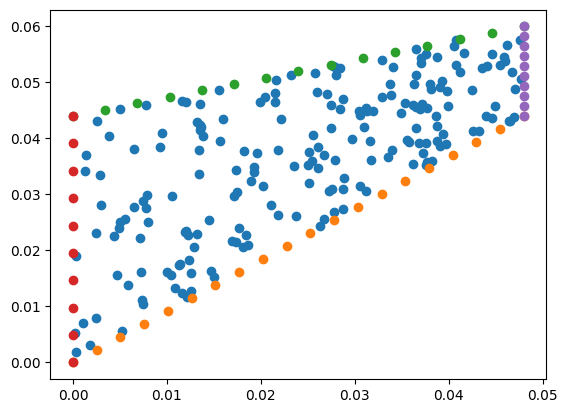

In [3]:
# step 1: Domain
corners = jnp.array([(0., 0.), (0, 0.044), (0.048, 0.060), (0.048, 0.044)]) 
domain = CooksDomainND
domain_init_kwargs = dict(
    corners=corners,
)
domain_init_kwargs

# Example 2D Plot
key = jax.random.PRNGKey(0)
all_params = {
    "static": {
        "domain": {
            "xd": 2,
            "corners": corners,
        }
    }
}

batch_shape = (10,20)  # for example
x_batch = domain.sample_interior(all_params, key, 'uniform', batch_shape)

batch_shapes = ((20,),(15,),(10,),(10,)) # bottom, top, left, right
x_boundaries = domain.sample_boundaries(all_params, key, 'grid', batch_shapes)

plt.scatter(x_batch[:, 0:1], x_batch[:, 1:2])
for x_batch_b in x_boundaries:
        plt.scatter(x_batch_b[:,0], x_batch_b[:,1], )

In [4]:
print(x_batch.shape, len(x_boundaries), x_boundaries[0].shape)
final_batch = jnp.vstack([x_batch] + x_boundaries)
print(final_batch.shape)

(200, 2) 4 (20, 2)
(255, 2)


In [5]:
# step 2: prbolem
# problem = CooksProblemForwardSoft
problem = CooksProblemForwardHard
problem_init_kwargs = dict(lambda_true= 4, mu_true = 5, 
                    nbc_points_right = 200, nbc_points_top=200, 
                    nbc_points_bottom=200, dbc_points_left=200, sd=0.1)
problem_init_kwargs

{'lambda_true': 4,
 'mu_true': 5,
 'nbc_points_right': 200,
 'nbc_points_top': 200,
 'nbc_points_bottom': 200,
 'dbc_points_left': 200,
 'sd': 0.1}

{'subdomain_xs': [array([0.   , 0.012, 0.024, 0.036, 0.048]), array([0.   , 0.015, 0.03 , 0.045, 0.06 ])], 'subdomain_ws': [array([0.018, 0.018, 0.018, 0.018, 0.018]), array([0.0225, 0.0225, 0.0225, 0.0225, 0.0225])], 'unnorm': (0.0, 1.0)}


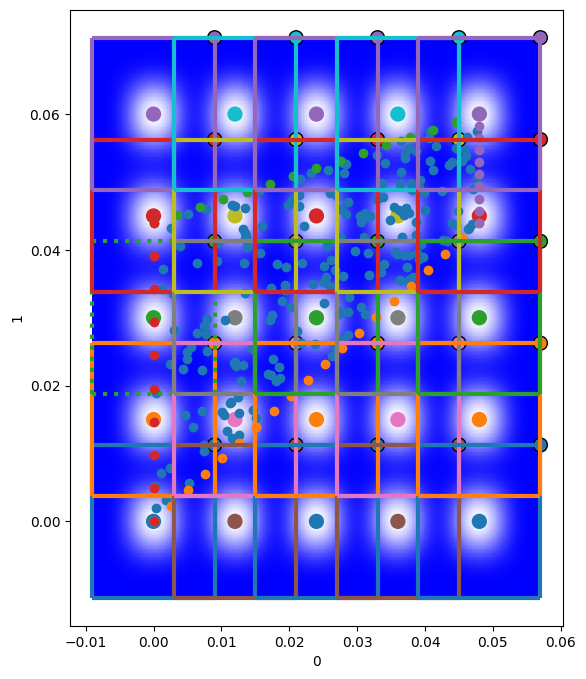

In [6]:
# step 3: decompostion
decomposition = RectangularDecompositionND
nsub = [5,5]
wo = 1.5
subdomain_xs = [np.linspace(0,0.048,nsub[0]), np.linspace(0,0.060,nsub[1])]
#subdomain_xs = [[0.012, 0.034], [0.022, 0.052]]
subdomain_ws=get_subdomain_ws(subdomain_xs, wo)
decomposition_init_kwargs = dict(
    subdomain_xs=subdomain_xs,
    subdomain_ws=get_subdomain_ws(subdomain_xs, wo),
    unnorm=(0.,1.),
)
print(decomposition_init_kwargs)

# plot 2D
ps_ = decomposition.init_params(subdomain_xs, subdomain_ws, (0,3))
all_params = {"static":{"decomposition":ps_[0]}, "trainable":{"decomposition":ps_[1]}}
m = all_params["static"]["decomposition"]["m"]
active = np.ones(m)

# active[1] = 0
active[2] = 2
decomposition.plot(all_params, active=active, show_norm=True, show_window=True)

# for x in x_batch:
#     plt.scatter(x[0], x[1])
plt.scatter(x_batch[:, 0:1], x_batch[:, 1:2])
for x_batch_b in x_boundaries:
        plt.scatter(x_batch_b[:,0], x_batch_b[:,1], )
plt.show()

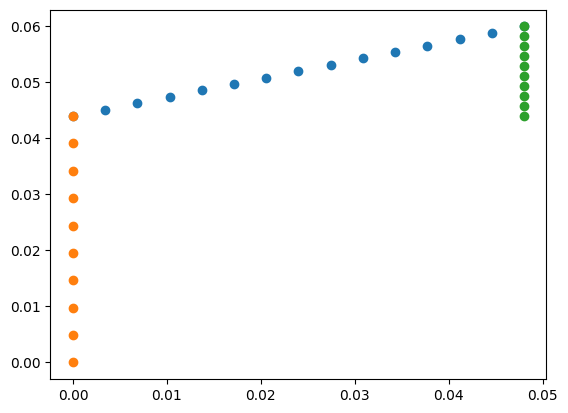

In [7]:
# tolerence check! Just to consider certain boundary poins
tolerence = 1e-6
for x_batch_b in x_boundaries:
    x, y = x_batch_b[:,0:1], x_batch_b[:,1:2]
    m_top = (0.06 -0.044) / (0.048 -0)
    b_top = 0.044                       # Create the line
    y_on_the_top = (jnp.abs(y-(m_top * x + b_top)) < tolerence) & (x>=0) & (x<=0.048) # replace >= and <= in main code
    if y_on_the_top.any():
        plt.scatter(x,y)
plt.show()

In [8]:
# Test the tolerence for applying Hard BC on the problem, if plots: Danger!
tolerence=1e-6
x, y = x_batch[:,0:1], x_batch[:,1:2]
m_top = (0.06 -0.044) / (0.048 -0)
b_top = 0.044                       # Create the line
y_on_the_top = (jnp.abs(y-(m_top * x + b_top)) < tolerence) & (x>=0) & (x<=0.048) # replace >= and <= in main code
if y_on_the_top.any():
    plt.scatter(x,y)
plt.show()

In [9]:
# step 4: network
network=FCN
network_init_kwargs = dict(
    layer_sizes = (2, 16, 5),
)

In [10]:
# step 5 scheduler # try with all active together
# scheduler = AllActiveSchedulerND
# scheduler_kwargs = dict()
scheduler = LineSchedulerRectangularND
scheduler_kwargs = dict(
    point=[0.], iaxis=0,
)

In [11]:
tag = "adaptive"
nc = (50,50)
epochs = 50000
h = len(network_init_kwargs["layer_sizes"]) - 2
p = sum(network_init_kwargs["layer_sizes"][1:-1])
run = f"FBPINN_{tag}_{problem.__name__}_{network.__name__}_{nc}-nCol_{epochs}-e_{h}-l_{p}-h_{wo}-wo_{LineSchedulerRectangularND.__name__}_{nsub}-nsub_"
run

'FBPINN_adaptive_CooksProblemForwardHard_FCN_(50, 50)-nCol_50000-e_1-l_16-h_1.5-wo_LineSchedulerRectangularND_[5, 5]-nsub_'

In [12]:

from fbpinns.constants import Constants

c = Constants(
    run=run,
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    scheduler=scheduler,
    scheduler_kwargs=scheduler_kwargs,
    ns=(nc,),# use 200 collocation points for training
    n_test=(50,50),# use 500 points for testing
    n_steps=epochs,# number of training steps
    clear_output=True,
    show_figures=False,
    test_freq=150000,
    skip_plot_at_first=True,
)
print(c)

run: FBPINN_adaptive_CooksProblemForwardHard_FCN_(50, 50)-nCol_50000-e_1-l_16-h_1.5-wo_LineSchedulerRectangularND_[5, 5]-nsub_
domain: <class 'cooksDomain.CooksDomainND'>
domain_init_kwargs: {'corners': Array([[0.   , 0.   ],
       [0.   , 0.044],
       [0.048, 0.06 ],
       [0.048, 0.044]], dtype=float32)}
problem: <class 'CooksMembrane.cooksProblem.CooksProblemForwardHard'>
problem_init_kwargs: {'lambda_true': 4, 'mu_true': 5, 'nbc_points_right': 200, 'nbc_points_top': 200, 'nbc_points_bottom': 200, 'dbc_points_left': 200, 'sd': 0.1}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.   , 0.012, 0.024, 0.036, 0.048]), array([0.   , 0.015, 0.03 , 0.045, 0.06 ])], 'subdomain_ws': [array([0.018, 0.018, 0.018, 0.018, 0.018]), array([0.0225, 0.0225, 0.0225, 0.0225, 0.0225])], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': (2, 16, 5)}
n_steps: 50000
scheduler

In [13]:
training_time = time.time()
FBPINNrun = FBPINNTrainer(c)
FBPINNrun.train()

training_time = time.time() - training_time
print(training_time)

[INFO] 2024-03-25 21:09:49 - <fbpinns.constants.Constants object at 0x000001F6C0A93E00>
run: FBPINN_adaptive_CooksProblemForwardHard_FCN_(50, 50)-nCol_50000-e_1-l_16-h_1.5-wo_LineSchedulerRectangularND_[5, 5]-nsub_
domain: <class 'cooksDomain.CooksDomainND'>
domain_init_kwargs: {'corners': Array([[0.   , 0.   ],
       [0.   , 0.044],
       [0.048, 0.06 ],
       [0.048, 0.044]], dtype=float32)}
problem: <class 'CooksMembrane.cooksProblem.CooksProblemForwardHard'>
problem_init_kwargs: {'lambda_true': 4, 'mu_true': 5, 'nbc_points_right': 200, 'nbc_points_top': 200, 'nbc_points_bottom': 200, 'dbc_points_left': 200, 'sd': 0.1}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.   , 0.012, 0.024, 0.036, 0.048]), array([0.   , 0.015, 0.03 , 0.045, 0.06 ])], 'subdomain_ws': [array([0.018, 0.018, 0.018, 0.018, 0.018]), array([0.0225, 0.0225, 0.0225, 0.0225, 0.0225])], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.

In [14]:
from FBPINNsModel.plot import load_FBPINN, load_PINN, exact_solution
from fbpinns.analysis import load_model

# run = "test"
# load model
c, model = load_model(run, rootdir="results/")

# Test model
from fbpinns.analysis import FBPINN_solution, PINN_solution
i, all_params, all_opt_states, active, u_test_losses = model
x_batch_test = domain.sample_interior(all_params=all_params, key=None, sampler="grid", batch_shape=(500,500))
out = FBPINN_solution(c, all_params, active, x_batch_test)

ux_test, uy_test, sigaxx_test, sigmayy_test, sigmaxy_test  = out[:,0:1],out[:,1:2],out[:,2:3],out[:,3:4],out[:,4:5]

[INFO] 2024-03-25 21:13:10 - Loading model from:
results/models/FBPINN_adaptive_CooksProblemForwardHard_FCN_(50, 50)-nCol_50000-e_1-l_16-h_1.5-wo_LineSchedulerRectangularND_[5, 5]-nsub_/model_00050000.jax
[INFO] 2024-03-25 21:13:12 - x_batch
[INFO] 2024-03-25 21:13:12 - (250000, 2), float32, ArrayImpl
[INFO] 2024-03-25 21:13:12 - x_take
[INFO] 2024-03-25 21:13:12 - (563932, 2), float32, ArrayImpl


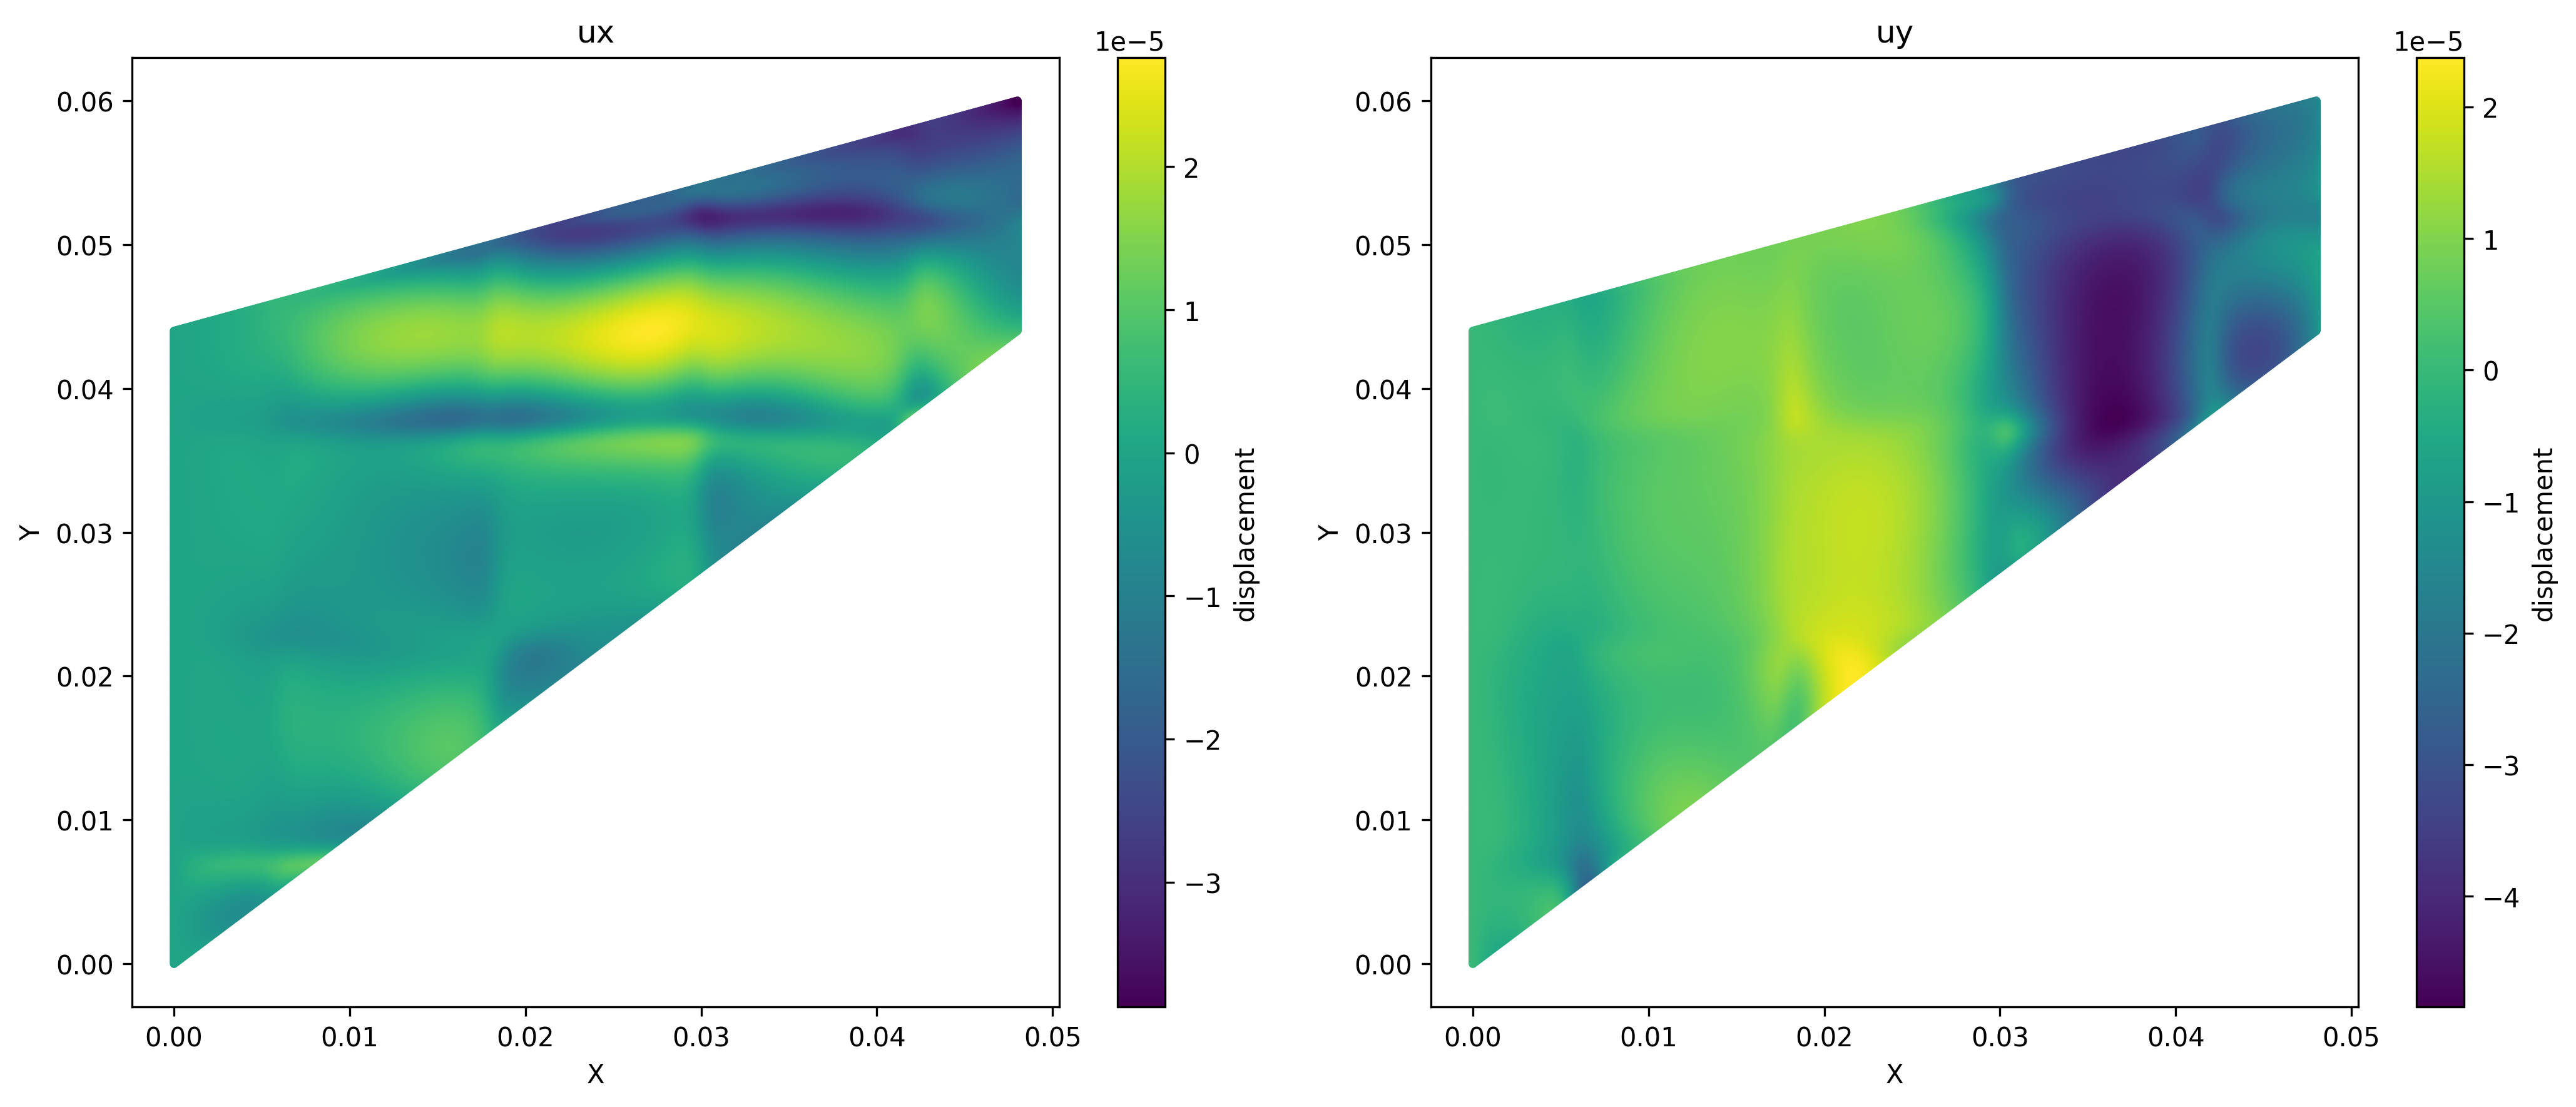

In [15]:
from CooksMembrane.util import plot_deformation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
plot_deformation(ux_test, x_batch_test,ax1,"ux")
plot_deformation(uy_test, x_batch_test,ax2,"uy")
plt.tight_layout()
plt.show()

## FBPINNs Vs FEM comparison

[INFO] 2024-03-25 21:19:42 - x_batch
[INFO] 2024-03-25 21:19:42 - (121, 2), float64, ndarray
[INFO] 2024-03-25 21:19:42 - x_take
[INFO] 2024-03-25 21:19:42 - (246, 2), float64, ndarray


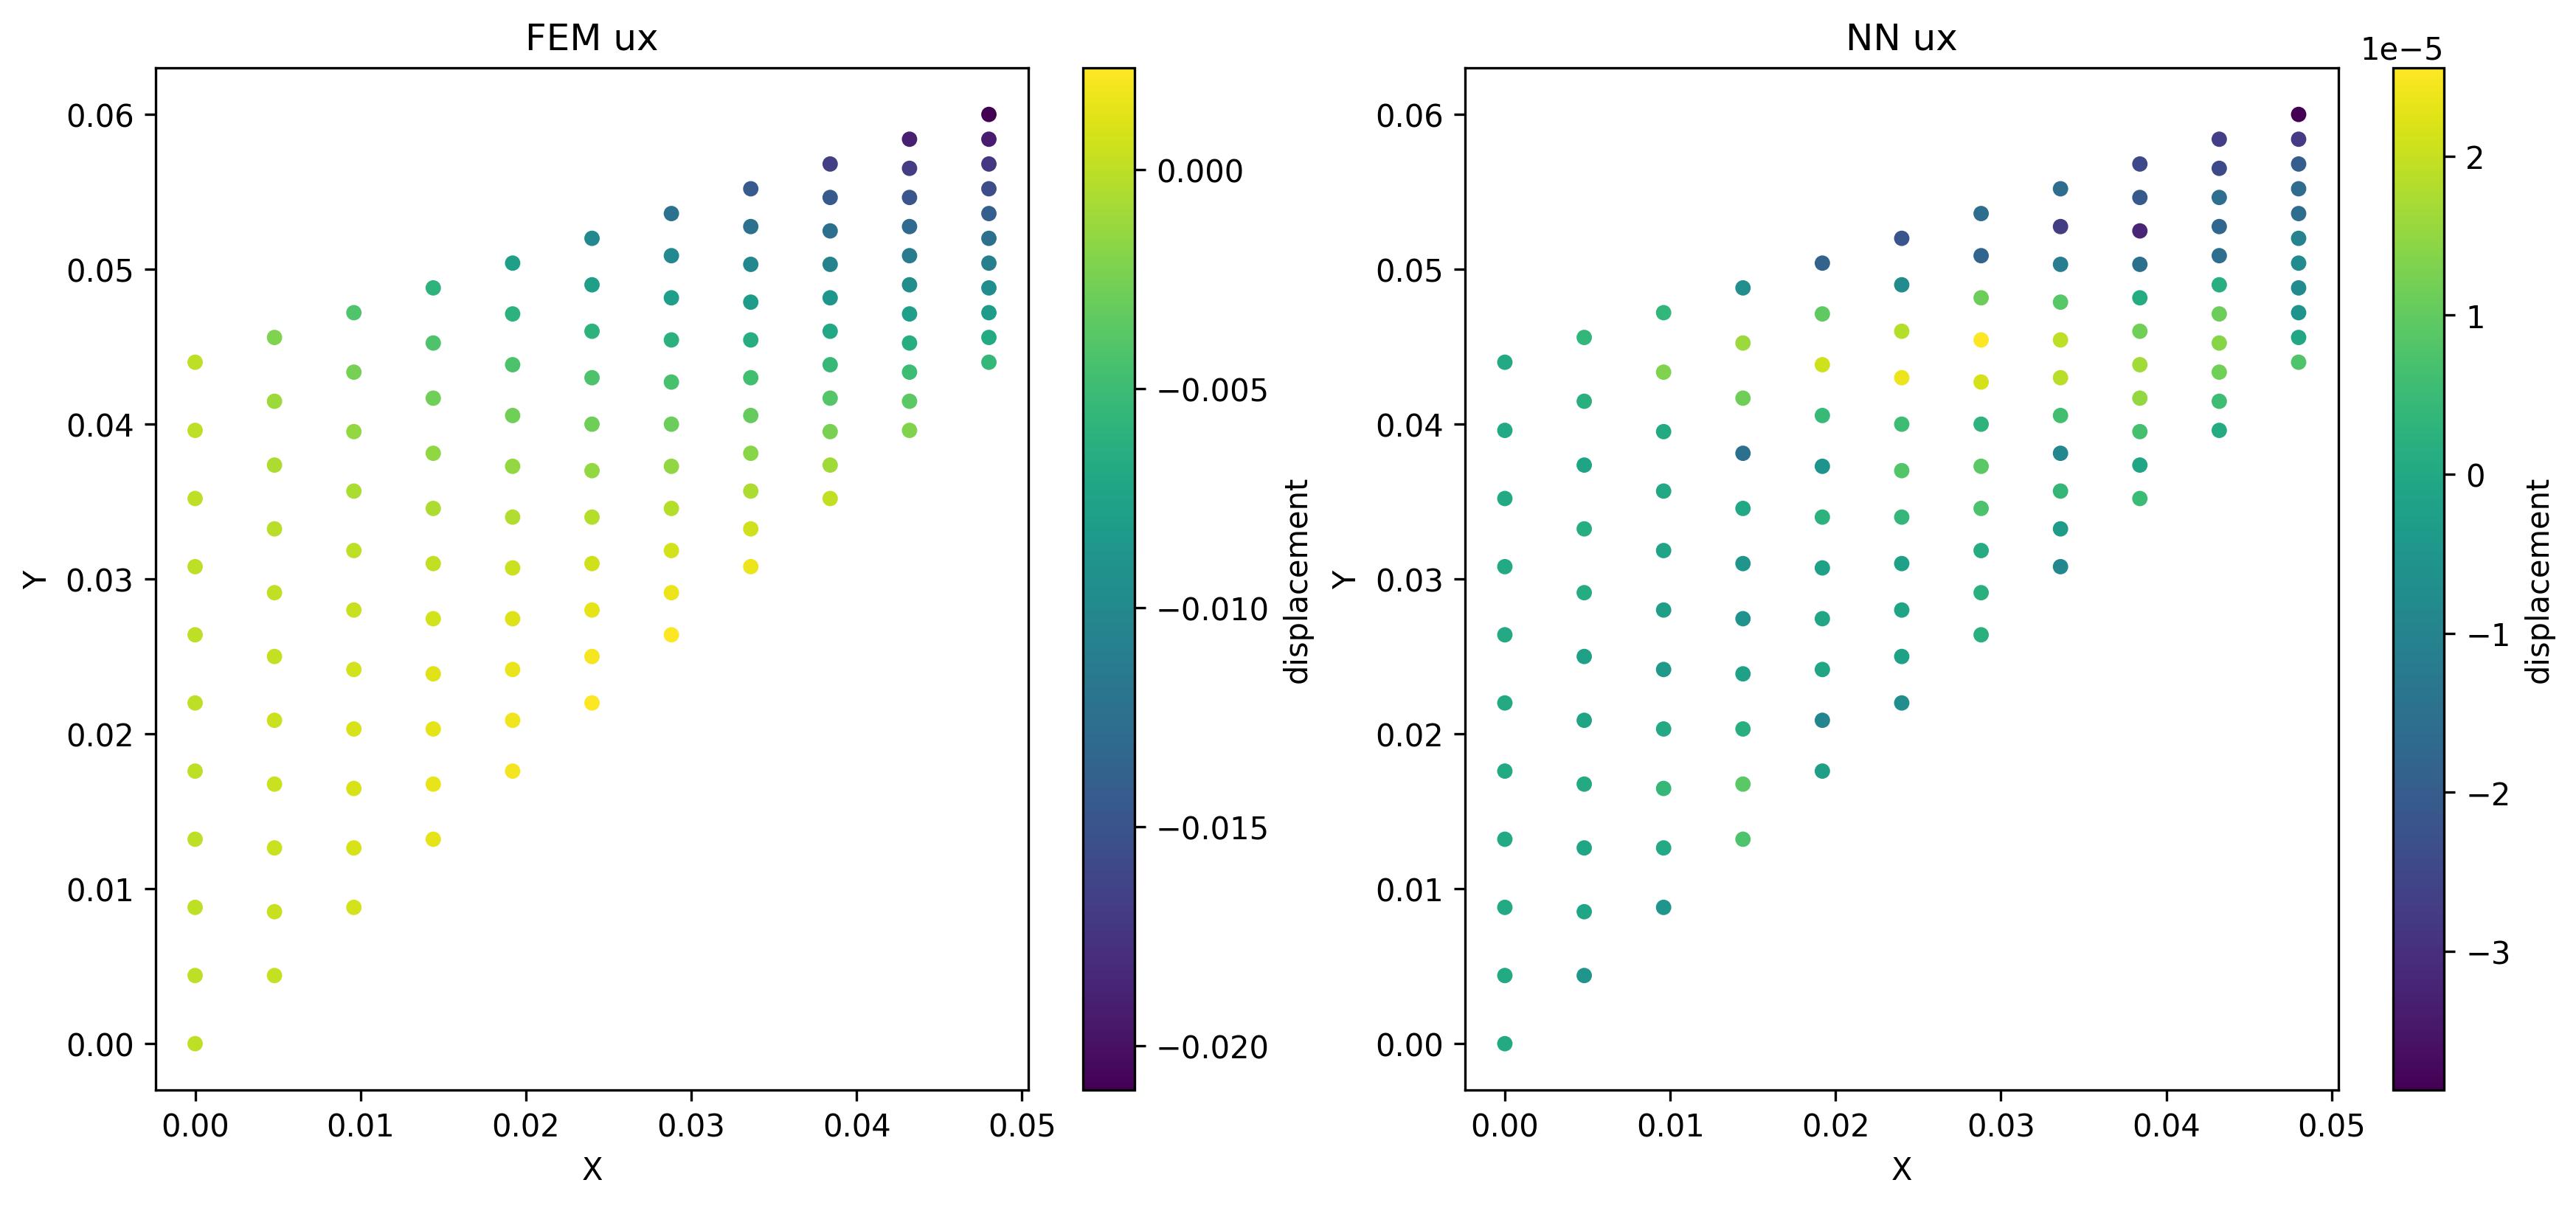

In [21]:
import pandas as pd 

FEM = pd.read_csv("FEM_result/stats.csv")

FEM = FEM[['u:0', 'u:1', 'Points:0', 'Points:1']].rename(columns={'u:0': 'ux', 'u:1': 'uy', 'Points:0': 'x', 'Points:1': 'y'})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
plot_deformation( FEM["ux"],FEM[['x', 'y']].values, ax1, "FEM ux", 16)

# NN sol
x_batch_test = FEM[['x', 'y']].values
out = FBPINN_solution(c, all_params, active, x_batch_test)

ux_test, uy_test, sigaxx_test, sigmayy_test, sigmaxy_test  = out[:,0:1],out[:,1:2],out[:,2:3],out[:,3:4],out[:,4:5]
plot_deformation(ux_test, x_batch_test, ax2, set_title="NN ux", point_size=16)


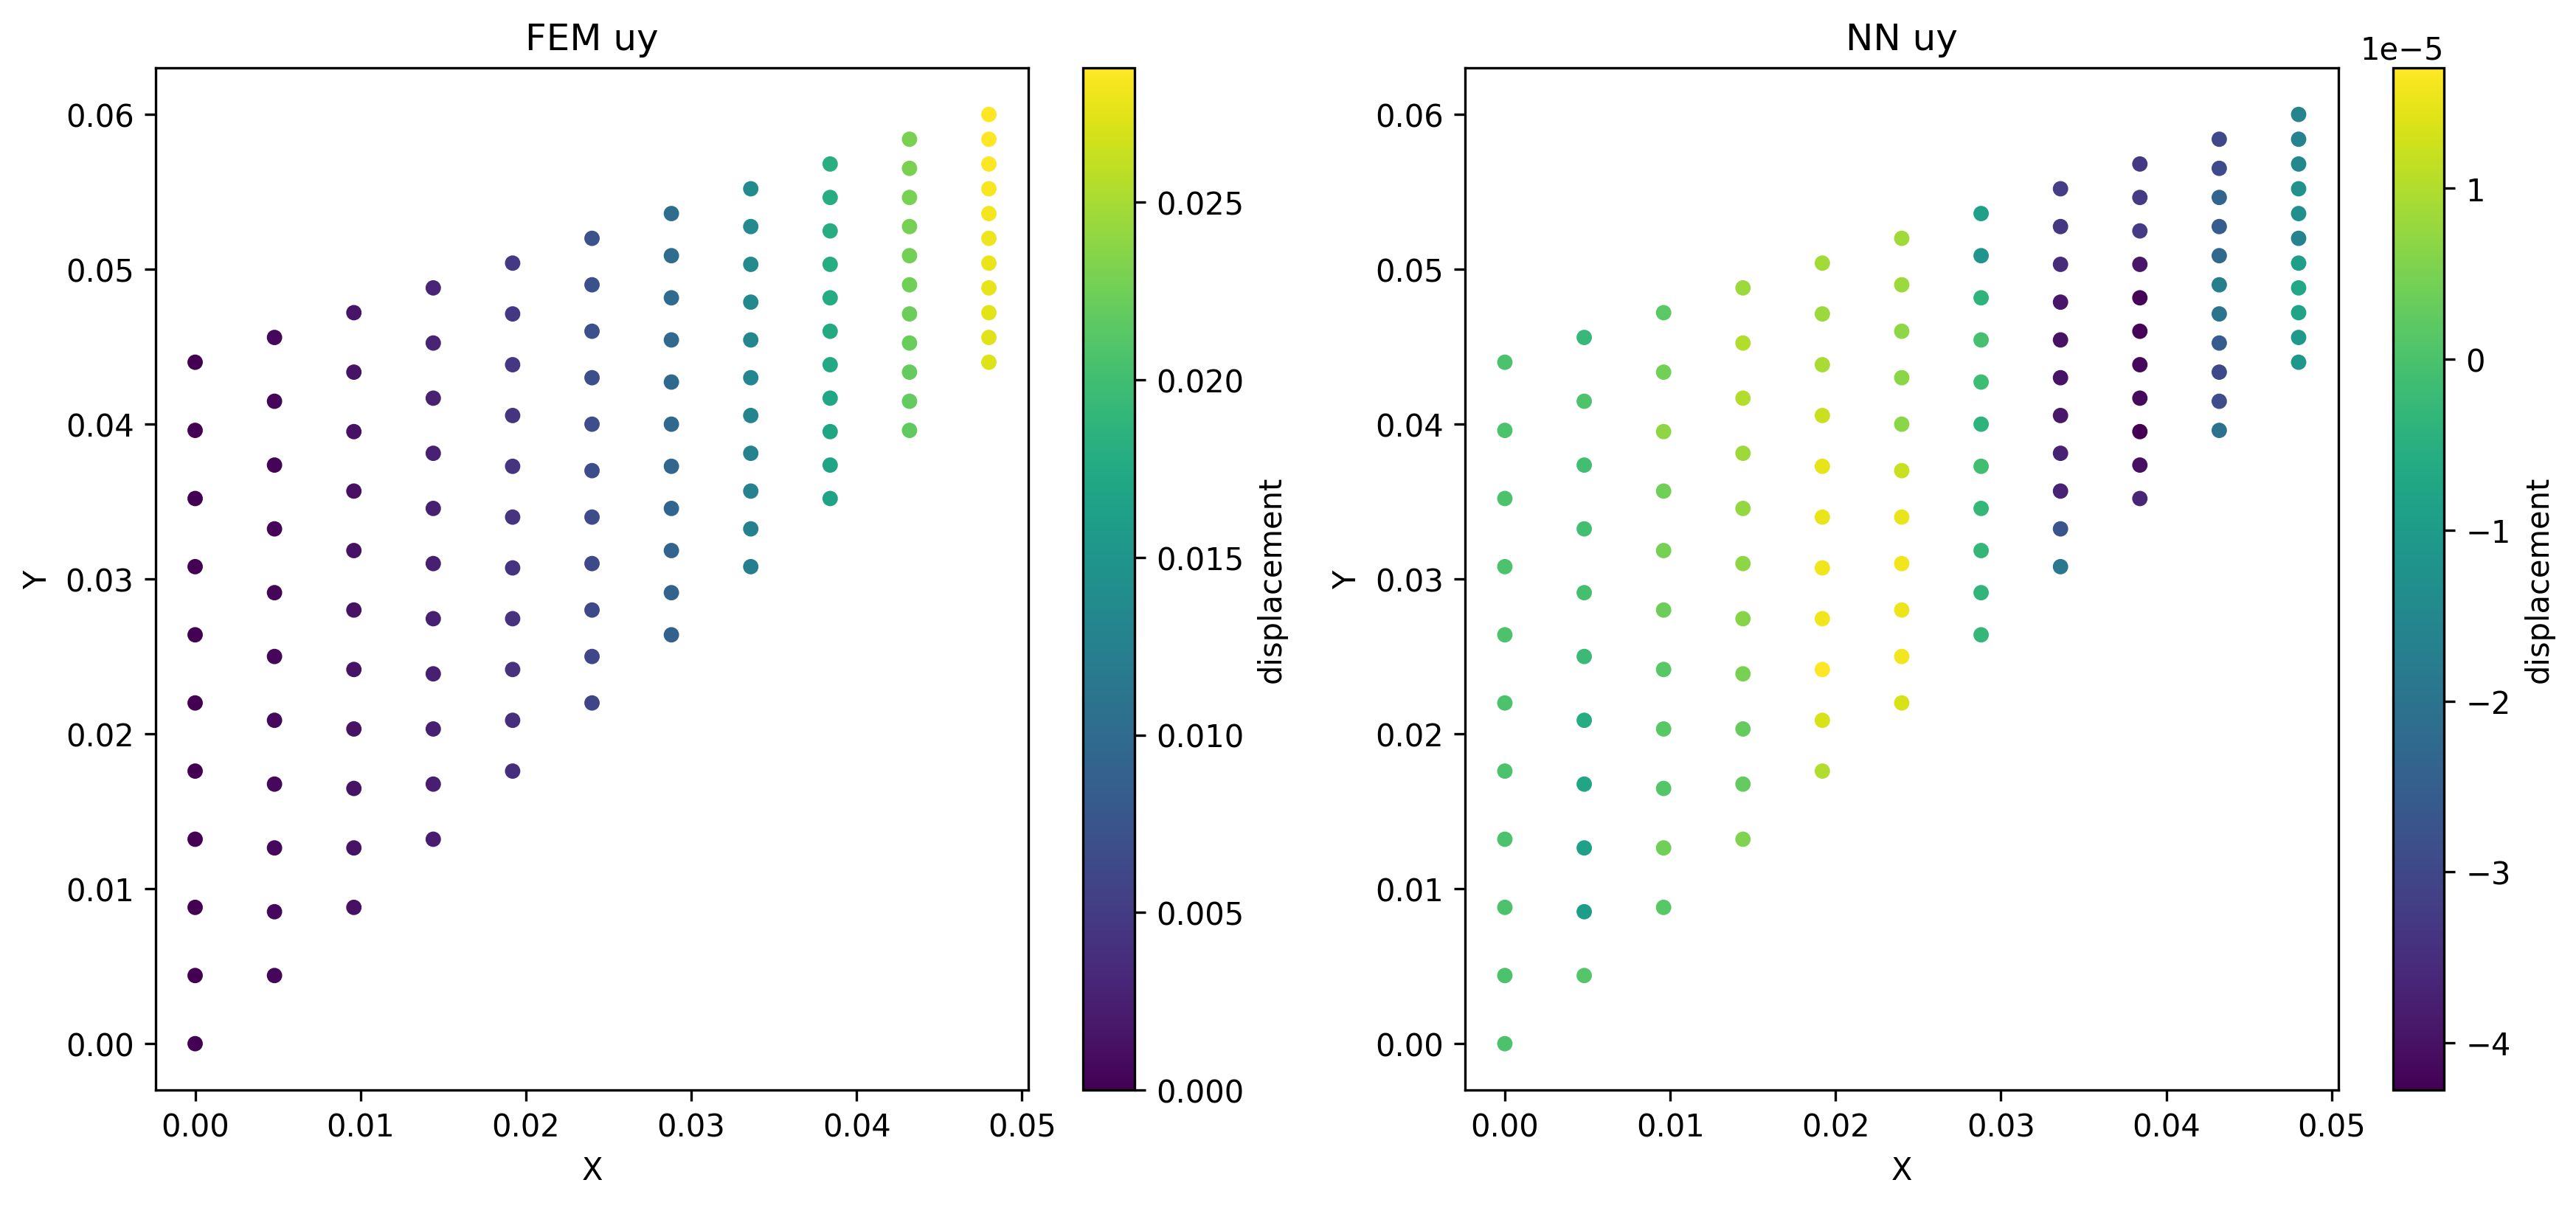

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
plot_deformation( FEM["uy"],FEM[['x', 'y']].values, ax1, "FEM uy", 16)
plot_deformation(uy_test, x_batch_test, ax2, set_title="NN uy", point_size=16)